# Satellite Acquisition

**BEFORE RUNNING THIS CODE: **Download the launch 12 GPS data [here](https://github.com/psas/Launch-12/blob/gh-pages/data/GPS/JGPS%40-32.041913222), and place it in the */resources* folder.

This notebook demonstrates the satellite acquisition proccess, in which we determine which satellites are overhead. 

## Background
This code implements the **parallel code phase search** algorithm, which is based on the mathematical concept of circular convolution. This method requires the usage of multiple fft operations, but it will find a satellite in the data (if one exists) in  single iteration. As with all of the algorithms, the parallel code phase search will need to be executed at multiple frequencies to account for the doppler shift as the satellite moves across the sky. It is possible that we will need to use a different algorithm when the code is running on an embedded platform.


## Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#import struct
#import math
#import heapq

##Grabs the GoldCode module from the root of the repo
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from GoldCode import GoldCode
from GPSData import IQData
from Acquisition import _GetSecondLargest
from Acquisition import acquire

## Import data File

As noted in the L-12 GPS data README, the sampling frequency is 4.092 MHz. and the IF is 0. Also note that the L1 signal hits the antenna at the 1.57542 GHz frequency (10.23 MHz x 154). This is dealt with by the hardware frontend, so we only have to concern ourselves with the 1.023 MHz BPSK modulated C/A code.

Additional information on file "JGPS@04.559925043" can be found at: https://github.com/psas/Launch-12/tree/gh-pages/data/GPS

In [2]:
# Need these to pass to importFile module
fs = 4.092*10**6 # Sampling Frequency [Hz]

#Testing has shown us that 14ms is a long enough section of data to get a good search result.
#Not that searching over a segment longer than 20ms runs the risk of including a bit transition in the 
    #navigation message. A bit transition will cause the search to fail.
NumberOfMilliseconds = 14  #14

SampleLength = NumberOfMilliseconds*10**(-3)
BytesToSkip = 0

data = IQData()

# Uncomment one of these lines to choose between Launch12 or gps-sdr-sim data
data.importFile('../resources/JGPS@04.559925043', fs, SampleLength, BytesToSkip)
#data.importFile('../resources/test.max', fs, SampleLength, BytesToSkip)
#data.importFile('../resources/test4092kHz.max', fs, SampleLength, BytesToSkip)

BinWidth = (fs/len(data.CData))
print("BinWidth is: %f [Hz]"%(BinWidth))

Opening a file.
File handle is: 49.
Total Samples to read: 57288
Total Bytes read: 28644.
Which equals 57288 IQ pairs.
Sample Length: 0.014000 seconds.
File is now closed.
BinWidth is: 71.428571 [Hz]


## Check out the imported data

We will plot the first 100 samples to see what the signal looks like.

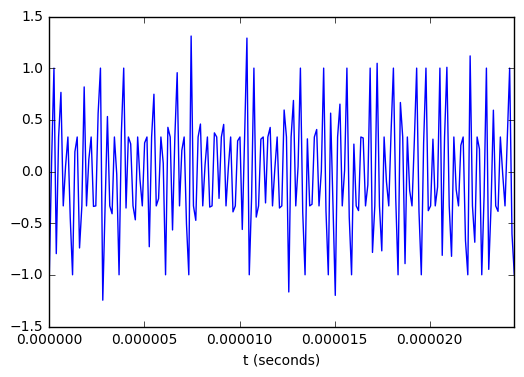

In [3]:
# Convert to real data
tReal, RData = data.ComplexToReal(data.CData)


plt.plot(tReal, RData)

# Set xaxis so first 100 samples are shown
xmin,xmax = plt.xlim()
plt.xlim(xmin,xmin + 100/(fs))

plt.xlabel("t (seconds)")
plt.show()

# FFT the data

We need to take the fft of the IQ datastream.

In [4]:
# Since we are using circular-convolution, nfft must be equal to the number of samples
nfft = data.Nsamples
deltaFreq = fs/nfft
print("Calculated deltaFreq: %f [Hz]" %(deltaFreq))

# Generate frequency lists for plotting fft
# Can use f for regular fft and fshift for shifted version
fs_kHz = fs/1000 #Make easier to read
f = np.linspace (0,fs_kHz,nfft, endpoint=False)
fshift = np.linspace(-fs_kHz/2,fs_kHz/2,nfft,endpoint=False)


# Reference data size section of book to pick the len param. Should be based sample rate
ffC = np.fft.fft(data.CData, nfft)
print(nfft)

Calculated deltaFreq: 71.428571 [Hz]
57288


# Get a Gold Code

See the GoldCodeGenerator notebook for information on how Gold Codes (aka C/A codes) are generated. 

For example purposes, we will first search for GPS SV 15. If you review historical GPS ephemeris data available online, you can see that SV 15 is visible at the time of Launch 12.

In [5]:
#code = np.repeat(CodeGen.getCode(1023), 4)

#Choose which satellite's C/A code is generated
Satellite = 15

# Create list of C/A code Taps, for simpler sat selection",
sat = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
           (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
           (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
           (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]

# Create Code Generator object for chosen Satellite
CodeGen = GoldCode(sat[Satellite - 1]) # Index starts at zero

# Generate a 1ms CA Code
CACode = CodeGen.getCode(1023, samplesPerChip = 4)

# Repeat entire array for each ms of data sampled
CACodeSampled = np.tile(CACode, int(data.sampleTime*1000))

# Complex Conjugate of Gold Code fft

Take the complex conjugate of the Gold Code [real(fft) - imag(fft)j], and then multiply it by the IQ fft. If this is done correctly there should be a spike about $10^7$ times as high as the noise. 

Our main output value from this is the **pseudo-signal to noise ratio**. This is the ratio of the max peak of the result and the second highest peak. 


Length of t: 57288
Length of IFFT: 57288


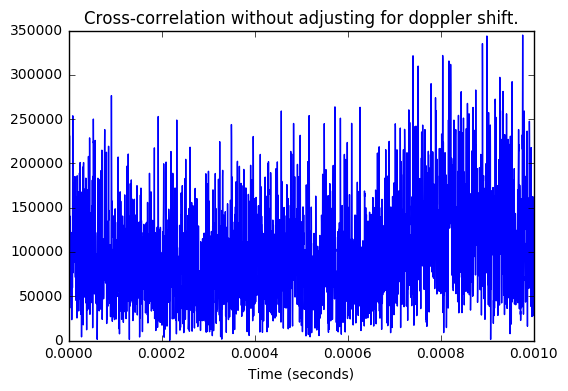

SNR: 0.300336
Max Value: 344817.777778, at freqshift: 0, with index 20362


In [6]:
Codefft = np.fft.fft(CACodeSampled, nfft)

GCConj = np.conjugate(Codefft)

result = np.fft.ifft(GCConj * ffC,nfft)

resultSQ = np.real(result*np.conjugate(result))

t = np.linspace(0,SampleLength,nfft,endpoint=True) 
print("Length of t: %d" %(len(t)))
print("Length of IFFT: %d" %(len(resultSQ)))

#Plotting
plt.plot(t,resultSQ)

# Zoom in to one ms
xmin,xmax = plt.xlim()
plt.xlim(xmin,xmin + 0.001)
plt.title("Cross-correlation without adjusting for doppler shift.")
plt.xlabel("Time (seconds)")
plt.show()


# Search for largest value in 1 ms worth of data
SecondLargestValue = _GetSecondLargest(resultSQ[0:int(fs*0.001)])

# Pseudo SNR
ResultsSNR = 10*np.log10(np.amax(resultSQ)/SecondLargestValue)
print("SNR: %f"%(ResultsSNR))

print("Max Value: %f, at freqshift: %d, with index %d"%(np.amax(resultSQ),0,np.argmax(resultSQ)))

## Shift frequency using multiplication by a complex exponential

Well, SV 15 seems to be nowhere to be found. The issue is that SV15 has a Doppler Shift as it moves across the sky. If it were directly overhead, we would not have to worry about it. We can go back to the historical data, and figure out that SV 15 should have a -1400Hz shift from our location. 

We can shift our data by 1400Hz by multiplying it by a complex exponential, and trying again.

$$ (I + jQ) * e^{j \omega t}$$

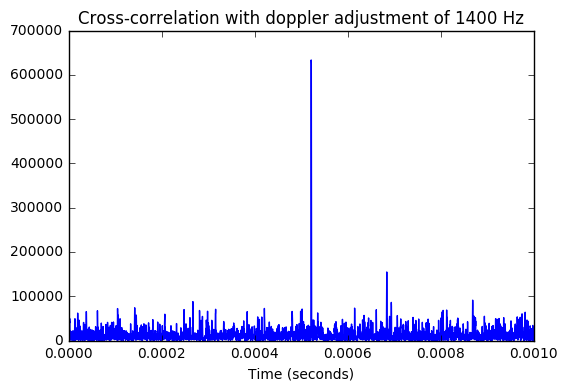

SNR: 6.121345
Max Value: 633417.501498, at freqshift: 1400, with index: 2133


In [7]:
freqShift = 1400 #-12 #[Hz] -20


# Initialize complex array
CDataShifted = data.CData*np.exp(1j*2*np.pi*freqShift*data.t)
fftCDataShifted = np.fft.fft(CDataShifted,nfft)

result = np.fft.ifft(GCConj * fftCDataShifted,nfft)
resultSQ = np.real(result*np.conjugate(result))
resultLog = 10*np.log10(resultSQ)

plt.plot(t,resultSQ)
plt.title("Cross-correlation with doppler adjustment of %d Hz"%(freqShift))
plt.xlabel("Time (seconds)")

# Zoom in to one ms
xmin,xmax = plt.xlim()
plt.xlim(xmin,xmin + 0.001)
plt.show()

# Search for largest value in 1 ms worth of data
SecondLargestValue = _GetSecondLargest(resultSQ[0:int(fs*0.001)])

# Pseudo SNR
ResultsSNR = 10*np.log10(np.amax(resultSQ)/SecondLargestValue)
print("SNR: %f"%(ResultsSNR))

print("Max Value: %f, at freqshift: %d, with index: %d"%(np.amax(resultSQ),freqShift,np.argmax(resultSQ)))

## Shift through frequency and satellite range

Now that we have seen what we should expect from the parallel code phase search, we can search across the frequency bands for doppler shifted satellites. We search 8kHz below, and 8kHz above the carrier frequency in 100Hz increments. More sensitive receivers can use larger bin sizes (500Hz or more instead of 100Hz). 

The outer loop iterates through each satellite, and executes an inner loop iterating over each frequency. The pseudo-SNR is returned from each iteration of the inner loop, and the outer loop saves the highest SNR for each satellite. 

Searching for SV 1...
Possible acquisition: Freq: -1200.0000, Peak2Second:   4.4523, Code Phase (samples): 2515.0000
Searching for SV 2...
Searching for SV 3...
Searching for SV 4...
Possible acquisition: Freq: 600.0000, Peak2Second:   5.8483, Code Phase (samples): 1901.0000
Searching for SV 5...
Searching for SV 6...
Searching for SV 7...
Possible acquisition: Freq: 3100.0000, Peak2Second:   5.6824, Code Phase (samples): 1747.0000
Searching for SV 8...
Searching for SV 9...
Searching for SV 10...
Searching for SV 11...
Possible acquisition: Freq: 600.0000, Peak2Second:   6.7513, Code Phase (samples): 2033.0000
Searching for SV 12...
Searching for SV 13...
Possible acquisition: Freq:   0.0000, Peak2Second:   6.9001, Code Phase (samples): 1471.0000
Searching for SV 14...
Searching for SV 15...
Possible acquisition: Freq: -1400.0000, Peak2Second:   6.1213, Code Phase (samples): 2133.0000
Searching for SV 16...
Searching for SV 17...
Searching for SV 18...
Searching for SV 19...
Searching

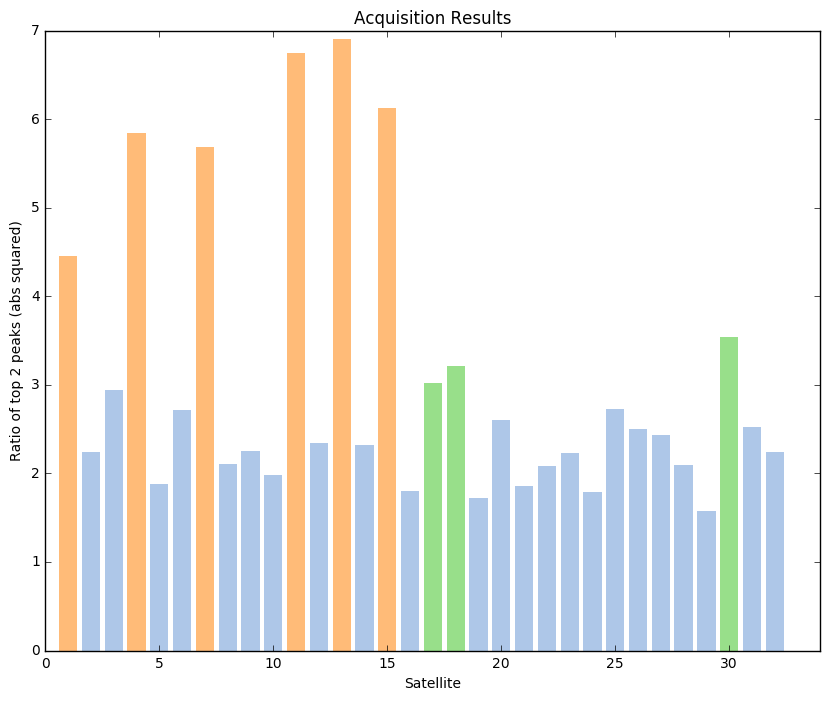

|-----+---------+----------+------------+---------+------------+------------|
| PRN | Max SNR | Peak-To- | P2S / P2S- | Doppler | Code Phase | Code Phase |
|     |  (dB)   |  Second  | mean [dB]] |   [Hz]  |   [Chips]  |  [Samples] |
|-----+---------+----------+------------+---------+------------+------------|
|  1    13.048     4.452       8.879       -1200      394.250      2515     |
|  4    14.759     5.848       9.514         600      547.750      1901     |
|  7     9.670     5.682       9.774        3100      586.250      1747     |
| 11    16.216     6.751      10.411         600      514.750      2033     |
| 13    15.137     6.900      10.509           0      655.250      1471     |
| 15    16.737     6.121      10.093       -1400      489.750      2133     |
| 17    10.951     3.016       7.204        9800      365.750      2629     |
| 18    12.031     3.215       7.338       -4800      666.000      1428     |
| 30     7.731     3.544       7.983        1200      672.500   

In [8]:
#Execute acquire function from Acquisition.py 
#r = acquire(data)
r = acquire(data, range(-10000, 11000, 100), range(1, 33))

In [9]:
print("|-----+---------+----------+------------+---------+------------+------------|")
print("| PRN | Max SNR | Peak-To- | P2S / P2S- | Doppler | Code Phase | Code Phase |")
print("|     |  (dB)   |  Second  | mean [dB]] |   [Hz]  |   [Chips]  |  [Samples] |")
print("|-----+---------+----------+------------+---------+------------+------------|")
for i in range(1,33):
    P2SToMeanP2SdB = 10*np.log10(  np.amax(r[i].PeakToSecond)/np.mean(r[i].PeakToSecond)  )        
    print("| %2d  %8.3f  %8.3f    %8.3f      %6d    %9.3f    %6d     |"
        %(i,r[i].MaxSNR, np.amax(r[i].PeakToSecond), P2SToMeanP2SdB , r[i].DopplerHz,r[i].CodePhaseChips, r[i].CodePhaseSamples))
print("|-----+---------+----------+------------+---------+------------+------------|")


|-----+---------+----------+------------+---------+------------+------------|
| PRN | Max SNR | Peak-To- | P2S / P2S- | Doppler | Code Phase | Code Phase |
|     |  (dB)   |  Second  | mean [dB]] |   [Hz]  |   [Chips]  |  [Samples] |
|-----+---------+----------+------------+---------+------------+------------|
|  1    13.048     4.452       8.879       -1200      394.250      2515     |
|  2    11.227     2.236       6.160       -2400      116.750      3625     |
|  3    11.335     2.946       7.481       -9500      394.750      2513     |
|  4    14.759     5.848       9.514         600      547.750      1901     |
|  5    10.057     1.875       5.522       -6200       17.250      4023     |
|  6    10.108     2.719       6.837       -2100      562.250      1843     |
|  7     9.670     5.682       9.774        3100      586.250      1747     |
|  8     9.575     2.102       5.994       -7000      539.000      1936     |
|  9     9.415     2.253       6.092         400      248.500   

###### For this data sample (Launch 12, 4 seconds after launch) we should see the following satellites:

Sat | S/N (dB-Hz) | doppler shift (Hz) | code phase (chips)
:----- | -------:| -------:| --------:
 1 | 13.287713  | -1209.276720 | 394.250000
 4 | 13.700614 | 600.950356 | 547.750000
 11 | 13.381992 | 612.980296 | 514.750000
 13 | 13.554054 | -12.064141 | 655.250000
 15 | 15.276798 | -1399.910091 | 489.750000
 
The 6 strongest signals are highlighted in the output plot, and the reciever will create a channel for each one for tracking.